<a href="https://colab.research.google.com/github/fractal2k/Learning-Deep-Learning/blob/master/torch_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hiddenlayer

In [ ]:
import numpy as np
import hiddenlayer as hl
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [ ]:
BATCH_SIZE = 100
EPOCHS = 50

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='', train=False, download=True, transform=transform)

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

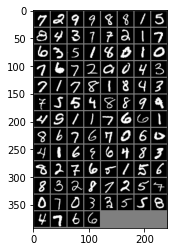

7 2 9 9 8 8 1 5 8 4 3 7 7 2 1 7 6 3 5 1 8 0 1 0 7 6 7 2 9 0 4 3 7 1 7 8 1 8 4 3 7 5 5 4 8 8 9 9 4 9 1 1 7 6 6 1 8 6 7 6 7 0 6 0 4 1 6 9 6 4 8 3 8 2 7 6 5 1 5 6 8 3 2 8 7 2 5 7 0 7 0 3 3 5 5 8 4 7 6 6


In [ ]:
def imshow(img):
    npimg = img.numpy()
    npimg = npimg / 2 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

trainiter = iter(trainloader)
images, labels = next(trainiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join([f'{label}' for label in labels]))

In [ ]:
# images.shape

In [ ]:
# torch.empty(100).normal_(mean=0., std=1.)

In [ ]:
# torch.as_tensor(np.array([np.random.normal(0., 1., 100) for i in range(4)]), dtype=torch.float32)

In [ ]:
# torch.ones_like(labels)

In [ ]:
def generate_noise_samples(batch_size):
    return torch.as_tensor(np.array([np.random.normal(0., 1., 100) for i in range(batch_size)]), dtype=torch.float32)

In [ ]:
class GeneratorNetwork(nn.Module):
    def __init__(self):
        super(GeneratorNetwork, self).__init__()
        self.dense1 = nn.Linear(100, 256)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.dense2 = nn.Linear(256, 512)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.dense3 = nn.Linear(512, 784)
    
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.dense1(x)))
        x = self.batchnorm2(F.relu(self.dense2(x)))
        x = torch.tanh(self.dense3(x))
        return x

gen = GeneratorNetwork()

In [ ]:
print(gen)

GeneratorNetwork(
  (dense1): Linear(in_features=100, out_features=256, bias=True)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=256, out_features=512, bias=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense3): Linear(in_features=512, out_features=784, bias=True)
)


In [ ]:
# torch.as_tensor(np.array(np.random.normal(0., 1., 100), ndmin=2), dtype=torch.float32)

In [ ]:
# gen_input = torch.as_tensor(np.array(np.random.normal(0., 1., 100), ndmin=2), dtype=torch.float32)
# gen_output = gen(gen_input)
# print(gen_output)

In [ ]:
class DiscriminatorNetwork(nn.Module):
    def __init__(self):
        super(DiscriminatorNetwork,  self).__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(784, 512)
        # self.batchnorm1 = nn.BatchNorm1d(512)
        self.dense2 = nn.Linear(512, 256)
        # self.batchnorm2 = nn.BatchNorm1d(256)
        self.dense3 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        return x

dis = DiscriminatorNetwork()

In [ ]:
print(dis)

DiscriminatorNetwork(
  (flatten): Flatten()
  (dense1): Linear(in_features=784, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
# Defining loss criterion for networks
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Defining Optimizers for both the networks
gen_optimizer = optim.Adam(gen.parameters())
dis_optimizer = optim.Adam(dis.parameters())

In [ ]:
# gen_history = hl.History()
# dis_history = hl.History()
# plot = hl.Canvas()

for epoch in range(EPOCHS):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Resetting discriminator gradients
        dis_optimizer.zero_grad()

        # ----Training the discriminator----
        # Real inputs
        real_outputs = dis(inputs)
        real_labels = torch.ones_like(real_outputs)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()  # Backpropagating real loss

        # Fake inputs
        gen_inputs = generate_noise_samples(BATCH_SIZE)
        fake_inputs = torch.reshape(gen(gen_inputs), (BATCH_SIZE, 1, 28, 28))
        fake_outputs = dis(fake_inputs)
        fake_labels = torch.zeros_like(fake_outputs)
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()  # Backpropagating fake loss

        total_dis_loss = real_loss + fake_loss  # Calculating total loss
        dis_optimizer.step()  # Updating discriminator parameters
        
        # Resetting generator gradients
        gen_optimizer.zero_grad()

        # ----Training Generator----
        gen_inputs = generate_noise_samples(BATCH_SIZE)
        gen_outputs = torch.reshape(gen(gen_inputs), (BATCH_SIZE, 1, 28, 28))
        dis_outputs = dis(gen_outputs)
        gen_labels = torch.ones_like(dis_outputs)
        gen_loss = criterion(dis_outputs, gen_labels)
        gen_loss.backward()  # Backpropagating generator loss
        gen_optimizer.step()  # Updating generator parameters

        # Updating loss plot after every 10th minibatch
        # if i % 10 == 0:
        #     dis_history.log(i, loss=total_dis_loss)
        #     gen_history.log(i, loss=gen_loss)
        #     plot.draw_plot([dis_history['loss'], gen_history['loss']])

        # Printing loss after every 100th minibatch
        if i % 100 == 99:
            print(f'[Epoch: {epoch + 1}, minibatch: {i + 1}] - Generator loss = {gen_loss}, Discriminator loss = {total_dis_loss}')

print('Finished Training')

[Epoch: 1, minibatch: 100] - Generator loss = 7.681963920593262, Discriminator loss = 0.3164970278739929
[Epoch: 1, minibatch: 200] - Generator loss = 7.766641616821289, Discriminator loss = 0.05185219272971153
[Epoch: 1, minibatch: 300] - Generator loss = 8.821392059326172, Discriminator loss = 0.20796461403369904
[Epoch: 1, minibatch: 400] - Generator loss = 6.084307670593262, Discriminator loss = 0.11771640181541443
[Epoch: 1, minibatch: 500] - Generator loss = 6.2378387451171875, Discriminator loss = 0.11970172822475433
[Epoch: 1, minibatch: 600] - Generator loss = 4.948756217956543, Discriminator loss = 0.09674186259508133
[Epoch: 2, minibatch: 100] - Generator loss = 6.506092071533203, Discriminator loss = 0.2165815830230713
[Epoch: 2, minibatch: 200] - Generator loss = 3.568044662475586, Discriminator loss = 0.3537708520889282
[Epoch: 2, minibatch: 300] - Generator loss = 5.4706854820251465, Discriminator loss = 0.3020324110984802
[Epoch: 2, minibatch: 400] - Generator loss = 5.

In [ ]:
def display_gen(img):
    npimg = img.detach().numpy()
    npimg = npimg / 2 + 0.5
    fig = plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(npimg[i, :, :], cmap='gray')
        plt.axis('off')

    plt.show()

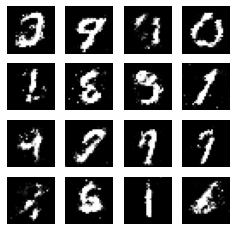

In [ ]:
pred_inputs = generate_noise_samples(16)
pred = torch.reshape(gen(pred_inputs), (16, 28, 28))
display_gen(pred)

In [ ]:
torch.save(gen.state_dict(), './gen_state_dict.pt')
torch.save(dis.state_dict(), './dis_state_dict.pt')

In [ ]:
new_gen = GeneratorNetwork()
new_gen.load_state_dict(torch.load('./gen_state_dict.pt'))

<All keys matched successfully>

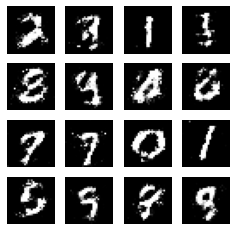

In [ ]:
new_inputs = generate_noise_samples(16)
new_preds = torch.reshape(new_gen(new_inputs), (16, 28, 28))
display_gen(new_preds)